In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

import numpy as np
import math

%reload_ext autoreload
%autoreload 2

![alternative text](../images/muograph_logo.png)


**<h1><center>POCA: tutorial</center></h1>**

The `EM` class is used to perform the **Expectation-Maximisation algorithm**, using both the **tracking information** provided by the `TrackingMST`and `Tracking_EM`. The latter computes the different geometries of interaction of muons with the volume voxels (`L`,`T`), as well as the weight matrix for each muon-voxel pair `W` needed for the maximisation step of the `EM` reconstruction algorithm.
The `POCA` class is instantiated at first, in order to obtain the PoCA locations to be used in `Tracking_EM`

### **I - Instanciation** 

First, let's instanciante the `TrackingMST` class. At first, we will consider a detector with perfect **spatial resolution** and **efficiency**:

In [2]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_in

GPU is not available. Using CPU


Collection of hits from 137,033 muons on 3 detector panels.

In [3]:
hits_out = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_out

Collection of hits from 137,033 muons on 3 detector panels.

In [4]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

tracks_in, tracks_out

(Collection of tracks from 137,033 muons 
  with perfect angular resolution.,
 Collection of tracks from 137,033 muons 
  with perfect angular resolution.)

In [5]:
output_dir = "../output_test/"
from muograph.tracking.tracking import TrackingMST
mst = TrackingMST(trackings=(tracks_in, tracks_out))
mst

Collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

The `POCA` class takes the following **arguments**:


- `tracking (Optional[TrackingMST])`: Instance of the TrackingMST class.

- `voi (Optional[Volume])`: Instance of the Volume class. If provided, muon events with poca locations outside the voi will be filtered out, the number of poca locations per voxel `n_poca_per_vox` as well as the voxel indices of each poca location will be computed.

- `poca_file (Optional[str])`: The path to the poca.hdf5 to load attributes from.

- `output_dir (Optional[str])`: Path to a directory where to save POCA attributes in a hdf5 file.

Let's instanciate the `POCA` class using an instances of `TrackingMST` and `Volume` class.

In [6]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -1200), # The position of the Volume of interest.
    dimension = (900, 600, 600), # The dimensions of the Volume of interest.
    voxel_width = 30) # The voxel size.

## **Tracking EM**

In [7]:
from muograph.reconstruction.tracking_em_test import TrackingEM

# use les muons to speed things up 
mst._filter_muons(mask=mst.dtheta > 1 * math.pi / 180)

t = TrackingEM(
    voi=voi,
    tracking=mst,
)


## **`all_poca`**

The **poca points** associated to ALL the tracks in `self.tracking`.

Usually when computing the poca points, we have to get rid of:

 - **Parallel events**: Poca point associated to parallel tracks cannot be computed.
 - **POCAs outside the voi**: Some POCA points land outisde the volume of interest.
  
As a consequence, `POCA` class only has 77,014 events whereas `TrackingMST` has 137,033 events.

`all_pocas` contains the same number of of events as `TrackingMST`.

In [8]:
t.tracking

Collection of tracks from 9,585 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

In [9]:
t.all_poca.size(), t.poca.poca_points.size()

(torch.Size([9585, 3]), torch.Size([9478, 3]))

In [10]:
t.poca

Collection of 9478 POCA locations.

## **`xyz_in_out_voi`**

Coordinates of the muon incoming/outgoing track when reaching the top / bottom of the voi.


- Coordinate of the muon incoming track when reaching the top of the voi:
            `xyz_in_out_voi[0][:, 1]`
- Coordinate of the muon incoming track when reaching the bottom of the voi:
`xyz_in_out_voi[0][:, 0]`
- Coordinate of the muon outgoing track when reaching the top of the voi:
`xyz_in_out_voi[1][:, 1]`
- Coordinate of the muon outgoing track when reaching the bottom of the voi:
`xyz_in_out_voi[1][:, 0]`

In [11]:
t.xyz_in_out_voi[0][:, 1], t.xyz_in_out_voi[0][:, 0] 

(tensor([[ 233.7290,   82.9040, -900.0000],
         [-110.6255,  -89.4229, -900.0000],
         [-133.4336,   17.9461, -900.0000],
         ...,
         [ -94.1943,  180.8167, -900.0000],
         [-154.1976, -125.4682, -900.0000],
         [-191.0845, -110.0090, -900.0000]]),
 tensor([[   35.8909,   202.3849, -1500.0000],
         [  -31.4045,    81.0611, -1500.0000],
         [ -215.4182,    85.1786, -1500.0000],
         ...,
         [ -156.9216,   327.3326, -1500.0000],
         [ -155.3616,   104.8969, -1500.0000],
         [ -212.2298,   198.1599, -1500.0000]]))

## **`xyz_enters_voi`**

Coordinates of the muon incoming track when entering the voi.

In [12]:
t.xyz_enters_voi.size()

torch.Size([9585, 3])


Sub-volumes



Voxel triggering


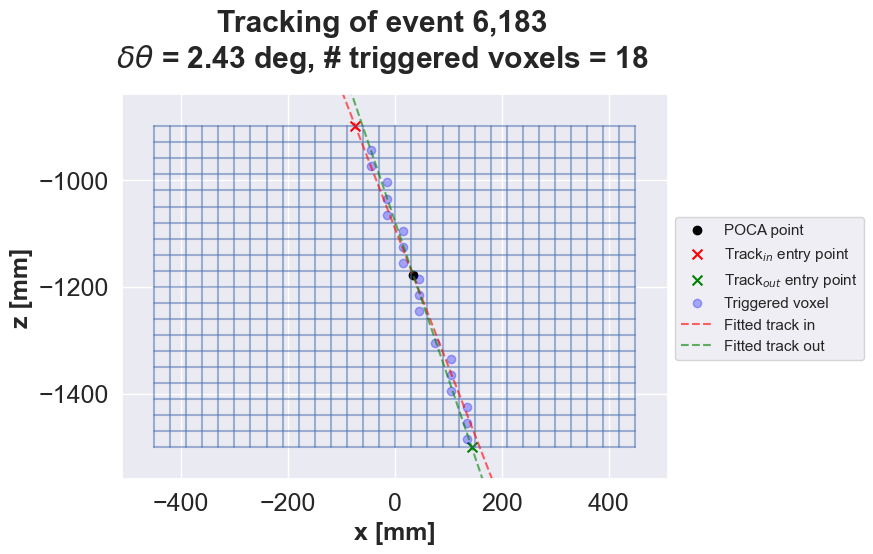

In [13]:
t.plot_event(
    event=np.random.randint(t.xyz_enters_voi.size()[0]),
    proj="XZ",
)

Some muons enter by the side of the volume not from the top:

1 - First we define a mask that selects muons that have a x position outside of the volume when reaching the top of the volume.

In [19]:
# Create a mask that selects only events entering from the left in x
mask_side = (t.xyz_in_out_voi[0][:, 1, 0] < voi.xyz_min[0])

mask_side, mask_side.size()

(tensor([False, False, False,  ..., False, False, False]), torch.Size([9585]))

2 - Get the index of events for which the mask is true, using the `nonzero()` method.

In [28]:
events_left = mask_side.nonzero().flatten()

type(events_left), events_left.size(), events_left

(torch.Tensor,
 torch.Size([68]),
 tensor([  83,  260,  581,  767, 1011, 1030, 1062, 1225, 1320, 1547, 1676, 1818,
         1848, 2022, 2358, 2360, 2376, 2738, 3051, 3059, 3141, 3254, 3331, 3492,
         3512, 3535, 3548, 3554, 3851, 3918, 4037, 4202, 4347, 4349, 4358, 4514,
         4729, 5052, 5264, 5426, 5573, 5581, 5884, 5923, 6045, 6071, 6332, 6426,
         6470, 6525, 7171, 7518, 7646, 7659, 7937, 7986, 8196, 8226, 8404, 8502,
         8908, 8920, 8969, 8984, 9102, 9267, 9357, 9523]))

3 - Now let's plot:

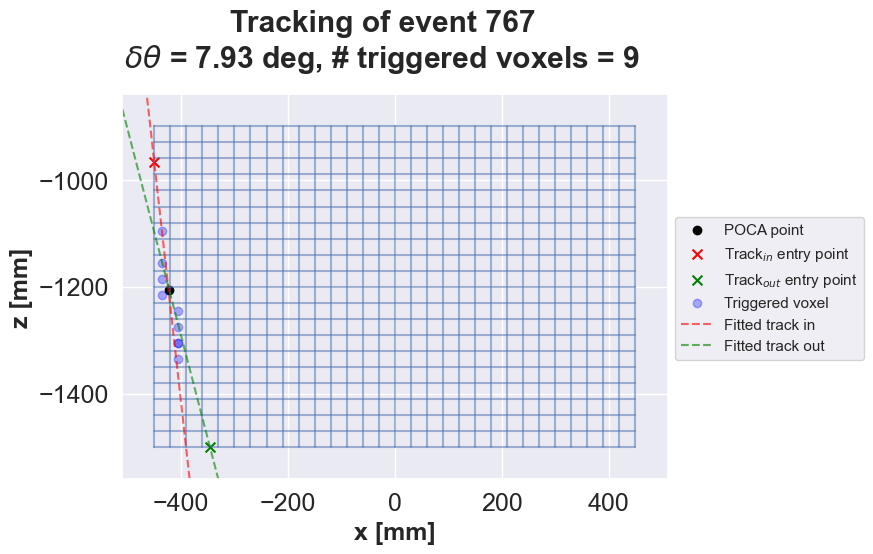

In [31]:
event_left = events_left[np.random.randint(len(events_left))]

t.plot_event(
    event=event_left,
    proj="XZ",
)